In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/

Mounted at /gdrive
/gdrive


In [ ]:
os.chdir('/gdrive/MyDrive/Image_Segementation_CS2/')
from google.colab import files
files.upload()


In [ ]:
!touch ~/.kaggle/kaggle.json

api_token = {"username":"sathishpython","key":"8b26115030388abc3635675cd3f6a6ea"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d theewok/chexnet-keras-weights

100% 25.4M/25.4M [00:00<00:00, 20.1MB/s]



In [ ]:
from zipfile import ZipFile
file_name  = 'chexnet-keras-weights.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Extraction completed')

Extraction completed


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from skimage import exposure
import cv2
from joblib import Parallel, delayed
!pip install pydicom
import pydicom
from pydicom import dcmread
from sklearn.utils import resample # Handle Imbalance
import pathlib
import PIL

     |████████████████████████████████| 1.9MB 5.8MB/s 


In [3]:
!pip install keras==2.3.1

     |████████████████████████████████| 378kB 5.4MB/s 
     |████████████████████████████████| 51kB 5.1MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [4]:
#!pip install keras_unet

In [5]:
#!pip install -U segmentation-models==0.2.1

In [7]:
import tensorflow_io

In [6]:
!pip install tensorflow_io

     |████████████████████████████████| 25.4MB 1.3MB/s 


In [7]:
import tensorflow as tf
import keras
import os
import imgaug.augmenters as iaa
from PIL import Image
# import albumentations as A
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
#from tensorflow.keras import layers,Model
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten, BatchNormalization, ReLU, Reshape,Flatten,MaxPooling2D,concatenate,UpSampling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, TensorBoard,CSVLogger
from keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
import random as rn
import tensorflow_io as tfio

# we are importing the pretrained unet from the segmentation models
# https://github.com/qubvel/segmentation_models
#import segmentation_models as sm
#from segmentation_models import Unet
# sm.set_framework('tf.keras')
keras.backend.set_image_data_format('channels_first')
#from segmentation_models.metrics import iou_score

Using TensorFlow backend.


In [8]:
from glob import glob
import pathlib
import pydicom as dicom


In [9]:
os.chdir('/gdrive/MyDrive/Image_Segementation_CS2/')

In [10]:
dataset = pd.read_csv('siim/train-rle.csv')
dataset.head()

ImageId                                      EncodedPixels
0  1.2.276.0.7230010.3.1.4.8323329.6904.151787520...                                                 -1
1  1.2.276.0.7230010.3.1.4.8323329.13666.15178752...  557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...
2  1.2.276.0.7230010.3.1.4.8323329.11028.15178752...                                                 -1
3  1.2.276.0.7230010.3.1.4.8323329.10366.15178752...  514175 10 1008 29 994 30 993 32 991 33 990 34 ...
4  1.2.276.0.7230010.3.1.4.8323329.10016.15178752...  592184 33 976 58 956 73 941 88 926 102 917 109...

In [ ]:
data_dir = pathlib.Path("siim")
train_read = sorted(data_dir.glob('dicom-images-train/**/*.dcm'))
test_read  = sorted(data_dir.glob('dicom-images-test/**/*.dcm'))

In [ ]:
missing_images = 0
train_df =[]
remove =[]

for j,i in enumerate(tqdm(train_read)):


  sample = dicom.dcmread(i) # reading each input
  train ={}
  train['UID'] = sample.SOPInstanceUID

  try: # try and except , to avoid throwing and error in case of missing files
    
    encoded_pixel = dataset[dataset['ImageId'] == train['UID']].values [0][1] # Checking each input is present in csv or not
    train['Encoded_pixel'] = encoded_pixel
  except:
    missing_images+=1
    remove.append('siim/dicom-images-train/'+sample.StudyInstanceUID+'/'+sample.SeriesInstanceUID+'/'+sample.SOPInstanceUID+'.dcm')
    # if the image details are not ppresent in CSV means, file is missing
  
  train['Path'] = 'siim/dicom-images-train/'+sample.StudyInstanceUID+'/'+sample.SeriesInstanceUID+'/'+sample.SOPInstanceUID+'.dcm' # saving for fucture references 
  
  train_df.append(train)




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [ ]:
df_main = pd.DataFrame(train_df,columns=['UID','Encoded_pixel','Path'])
df_main.head()

UID  ...                                               Path
0  1.2.276.0.7230010.3.1.4.8323329.1000.151787516...  ...  siim/dicom-images-train/1.2.276.0.7230010.3.1....
1  1.2.276.0.7230010.3.1.4.8323329.10000.15178752...  ...  siim/dicom-images-train/1.2.276.0.7230010.3.1....
2  1.2.276.0.7230010.3.1.4.8323329.10001.15178752...  ...  siim/dicom-images-train/1.2.276.0.7230010.3.1....
3  1.2.276.0.7230010.3.1.4.8323329.10002.15178752...  ...  siim/dicom-images-train/1.2.276.0.7230010.3.1....
4  1.2.276.0.7230010.3.1.4.8323329.10003.15178752...  ...  siim/dicom-images-train/1.2.276.0.7230010.3.1....

[5 rows x 3 columns]

In [ ]:
df_main = df_main.loc[~df_main['Path'].isin(remove)] #remove the row which dont have image.
df_main.head()

UID  ...                                               Path
0  1.2.276.0.7230010.3.1.4.8323329.1000.151787516...  ...  siim/dicom-images-train/1.2.276.0.7230010.3.1....
1  1.2.276.0.7230010.3.1.4.8323329.10000.15178752...  ...  siim/dicom-images-train/1.2.276.0.7230010.3.1....
2  1.2.276.0.7230010.3.1.4.8323329.10001.15178752...  ...  siim/dicom-images-train/1.2.276.0.7230010.3.1....
3  1.2.276.0.7230010.3.1.4.8323329.10002.15178752...  ...  siim/dicom-images-train/1.2.276.0.7230010.3.1....
4  1.2.276.0.7230010.3.1.4.8323329.10003.15178752...  ...  siim/dicom-images-train/1.2.276.0.7230010.3.1....

[5 rows x 3 columns]

In [ ]:
df_downsampled = df_main[df_main['Encoded_pixel']!= '-1']
df_downsampled.drop('UID',axis=1,inplace=True)
df_downsampled.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Encoded_pixel                                               Path
6   209126 1 1019 6 1015 10 1012 13 1010 14 1008 1...  siim/dicom-images-train/1.2.276.0.7230010.3.1....
13  49820 3 1017 11 1012 13 1009 16 1007 18 1006 1...  siim/dicom-images-train/1.2.276.0.7230010.3.1....
14  261328 6 1015 11 1011 15 1007 18 1004 21 1002 ...  siim/dicom-images-train/1.2.276.0.7230010.3.1....
18  592184 33 976 58 956 73 941 88 926 102 917 109...  siim/dicom-images-train/1.2.276.0.7230010.3.1....
28  530522 1 1022 3 1019 6 1017 7 1016 9 1014 10 1...  siim/dicom-images-train/1.2.276.0.7230010.3.1....

In [ ]:
df_main.to_csv('Main_CS2_SIIM_All.csv',index=False)

In [ ]:
df_downsampled.to_csv('Main_CS2_SIIM.csv',index=False)

In [11]:
# read csv file
df_main  = pd.read_csv('Main_CS2_SIIM_All.csv')
df_downsampled  = pd.read_csv('Main_CS2_SIIM.csv')

In [12]:
df_main.head()

UID  ...                                               Path
0  1.2.276.0.7230010.3.1.4.8323329.1000.151787516...  ...  siim/dicom-images-train/1.2.276.0.7230010.3.1....
1  1.2.276.0.7230010.3.1.4.8323329.10000.15178752...  ...  siim/dicom-images-train/1.2.276.0.7230010.3.1....
2  1.2.276.0.7230010.3.1.4.8323329.10001.15178752...  ...  siim/dicom-images-train/1.2.276.0.7230010.3.1....
3  1.2.276.0.7230010.3.1.4.8323329.10002.15178752...  ...  siim/dicom-images-train/1.2.276.0.7230010.3.1....
4  1.2.276.0.7230010.3.1.4.8323329.10003.15178752...  ...  siim/dicom-images-train/1.2.276.0.7230010.3.1....

[5 rows x 3 columns]

# **MODEL**


# **Data Sampling** 


---
To iterate faster and handle data imbalance, instead of upsampling the minority class, I downsample the majority class per epoch. However, to avoid wasting data, I sample different instances from the majority class per epoch.

For this problem, downsample would help


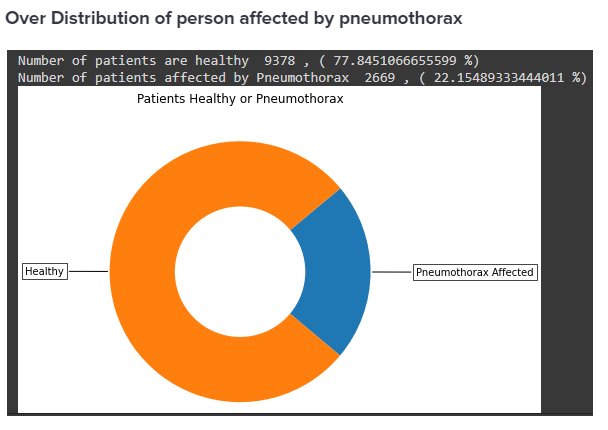

In [13]:
file_path  = df_downsampled['Path'].values
labels     = df_downsampled['Encoded_pixel'].values


In [14]:
import mask_functions #this .py has been provided by the host of the competition to convert the RLE values to a mask and vice versa

In [15]:
mask = np.zeros((len(df_downsampled),256,256,1),dtype=np.bool)

for j,i in tqdm(enumerate(df_downsampled['Encoded_pixel'].values)):
  #if i !='-1':
  a = (Image.fromarray(mask_functions.rle2mask(i,1024,1024).T).resize((256,256),resample=Image.BILINEAR))
  a = np.array(a)
  a = np.expand_dims(a,axis=-1)
  mask[j] = a
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
# train and test split
train_path = []
train_mask = []
test_path = []
test_mask =[]

train_len  = len(df_downsampled) - int(len(df_downsampled)* 0.20)
test_len   = int(len(df_downsampled)* 0.20)
count = 0

for i in tqdm(range(len(df_downsampled))):
  if count <= train_len:
    train_path.append(file_path[i])
    train_mask.append(mask[i])
    count +=1
  else:
    test_path.append(file_path[i])
    test_mask.append(mask[i])



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


In [17]:
train_path = np.array(train_path)
test_path = np.array(test_path)

## Why use Tf.Dataset pipeline?

<pre>

<font color ='blue'>
The tf. data API enables you to build complex input pipelines from simple, reusable pieces. For example, the pipeline for an image model might aggregate data from files in a distributed file system, apply random perturbations to each image, and merge randomly selected images into a batch for training.
The Dataset API allows you to build an asynchronous, highly optimized data pipeline to prevent your GPU from data starvation. It loads data from the disk (images or text), applies optimized transformations, creates batches, and sends it to the GPU. Former data pipelines made the GPU wait for the CPU to load the data, leading to performance issues.

</font>
</pre>

In [18]:
train_ds = tf.data.Dataset.from_tensor_slices((train_path,train_mask))
test_ds = tf.data.Dataset.from_tensor_slices((test_path,test_mask))


## Why Augumentation

</pre>
<font color='blue'>

It exposes the model to various scenarios that the model might face in the testing data. Data augmentation is an integral process in deep learning, as in deep learning we need large amounts of data and in some cases, it is not feasible to collect thousands or millions of images, so data augmentation comes to the rescue.
It helps us to increase the size of the dataset and introduce variability in the dataset.
    </font>
    </pre>

In [19]:
#Augumentation
def augment(image,label):
  a=tf.random.uniform((),minval=0,maxval=1)
  print('*'*50)
  print(int(a))
  print('*'*50)
  if a<0.2:
    print('1')
    image=tf.image.flip_left_right(image)
    label=tf.image.flip_left_right(label)
  if a<0.4 and a>0.2:
    print('2')
    image = tf.image.random_brightness(image, max_delta=0.15) # Random brightness
  if a<0.6 and a>0.4:
    print('3')
    image=tf.image.adjust_gamma(image, gamma=tf.random.uniform((),minval=0,maxval=1), gain=1)
  if a<0.8 and a>0.6:
    print('4')
    image=tf.image.random_contrast(image,lower=0.2,upper=0.3)
  if a<1.0 and a>0.8:
    print('5')
    image=tf.image.random_saturation(image, lower=2, upper=5)
  print(type(image))  
  return image, label

In [20]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  #image_bytes = tf.io.read_file(img)
  image = tfio.image.decode_dicom_image(img, dtype=tf.uint8,color_dim=True,scale='preserve')

  image = tf.image.convert_image_dtype(image, tf.float32)#converting the image to tf.float32
  image=tf.squeeze(image,[0]) #squeezing the image because the file is of the shape (1,1024,1024,1) and we want (1024,1024,3) 
  b = tf.constant([1,1,3], tf.int32) 
  image=tf.tile(image,b)
  image=tf.image.resize(image,size=[256,256]) #the image is of the shape (1024,1024,1) to make it (1024,1024,3) I am using tf.tile
  # resize the image to the desired size
  return image
  
def process_path(file_path,label):
  img = tf.io.read_file(file_path) #reading the image from the file path
  img = decode_img(img) #passing the image to the function
  return img,label

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(process_path,num_parallel_calls=AUTOTUNE)
test_ds =  test_ds.map(process_path,num_parallel_calls=AUTOTUNE)


In [21]:
#train_ds= train_ds.map(augment,num_parallel_calls=AUTOTUNE) 

In [22]:
def set_shapes(img,label,img_shape=(256,256,3)):
  img.set_shape(img_shape)
  label.set_shape((256,256,1))
  return img, label

In [23]:
train_ds = train_ds.map(set_shapes,num_parallel_calls=AUTOTUNE) #mapping the file paths to the above function
test_ds = test_ds.map(set_shapes,num_parallel_calls=AUTOTUNE)

**We are decreasing the batch size because Google colab GPU tensor OOM(out of memory) error**

In [37]:
train_dataset_new  = train_ds.batch(16).cache().prefetch(1920)
test_dataset_new  =  test_ds.batch(16).cache().prefetch(1920)

In [28]:
train_ds

<ParallelMapDataset shapes: ((256, 256, 3), (256, 256, 1)), types: (tf.float32, tf.bool)>

In [29]:
train_dataset_new

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.bool)>

#  UNET -  ChexNet as Bonebone

In [65]:
tf.keras.backend.clear_session()

In [66]:
# Metrics 
def dice_coeff(actual,predicted,smooth=1):
  Actual = K.flatten(actual)
  Predict = K.flatten(predicted)
  intersection  = K.sum(Actual *Predict)
  return ((2.* intersection + smooth) / (K.sum(Actual) +K.sum(Predict) +smooth))

In [67]:
#refered the architecture from the segmentation_model package

#We are not using the inbuilt package becuase of tensorflow compatability issues
from tensorflow.keras import Model
K.set_image_data_format('channels_last')

dense_net_121 = tf.keras.applications.DenseNet121(input_shape=[256,256,3],include_top=False,pooling='avg')

#Freezing some layers
for layer in dense_net_121.layers[-100:]:
    layer.trainable = False
base_model_output = tf.keras.layers.Dense(units=14,activation='relu')(dense_net_121.output)
base_model = Model(inputs = dense_net_121.input,outputs=base_model_output)
base_model.load_weights('brucechou1983_CheXNet_Keras_0.3.0_weights.h5')
output_layer = tf.keras.layers.Dense(1,activation='sigmoid')(base_model.layers[-2].output)
model = Model(inputs=base_model.inputs, outputs=output_layer)
model1=tf.keras.layers.UpSampling2D((2,2))(model.layers[-3].output)
model1=tf.keras.layers.concatenate([model1,model.get_layer('pool4_conv').output])
model1=tf.keras.layers.Conv2D(256,(3,3),padding='same',use_bias=False,kernel_initializer='glorot_uniform')(model1)
model1=tf.keras.layers.BatchNormalization()(model1)
model1=tf.keras.layers.Activation('relu')(model1)
model1=tf.keras.layers.Conv2D(256,(3,3),padding='same',use_bias=False,kernel_initializer='glorot_uniform')(model1)
model1=tf.keras.layers.BatchNormalization()(model1)
model1=tf.keras.layers.Activation('relu')(model1)
model1=tf.keras.layers.UpSampling2D((2,2))(model1)
model1=tf.keras.layers.concatenate([model1,model.get_layer('pool3_conv').output])
model1=tf.keras.layers.Conv2D(128,(3,3),padding='same',use_bias=False,kernel_initializer='glorot_uniform')(model1)
model1=tf.keras.layers.BatchNormalization()(model1)
model1=tf.keras.layers.Activation('relu')(model1)
model1=tf.keras.layers.Conv2D(128,(3,3),padding='same',use_bias=False,kernel_initializer='glorot_uniform')(model1)

#Reduceing the depth of UNET
model1= tf.keras.layers.Dropout(0.5)(model1)

model1=tf.keras.layers.BatchNormalization()(model1)
model1=tf.keras.layers.Activation('relu')(model1)
model1=tf.keras.layers.UpSampling2D((2,2))(model1)
model1=tf.keras.layers.concatenate([model1,model.get_layer('pool2_conv').output])
model1=tf.keras.layers.Conv2D(64,(3,3),padding='same',use_bias=False,kernel_initializer='glorot_uniform')(model1)
model1=tf.keras.layers.BatchNormalization()(model1)
model1=tf.keras.layers.Activation('relu')(model1)
model1=tf.keras.layers.Conv2D(64,(3,3),padding='same',use_bias=False,kernel_initializer='glorot_uniform')(model1)
model1=tf.keras.layers.BatchNormalization()(model1)
model1=tf.keras.layers.Activation('relu')(model1)
model1=tf.keras.layers.UpSampling2D((2,2))(model1)
model1=tf.keras.layers.concatenate([model1,model.get_layer('conv1/relu').output])
model1=tf.keras.layers.Conv2D(32,(3,3),padding='same',use_bias=False,kernel_initializer='glorot_uniform')(model1)

#Reduceing the depth of UNET
model1= tf.keras.layers.Dropout(0.7)(model1)


model1=tf.keras.layers.BatchNormalization()(model1)
model1=tf.keras.layers.Activation('relu')(model1)
model1=tf.keras.layers.Conv2D(32,(3,3),padding='same',use_bias=False,kernel_initializer='glorot_uniform')(model1)
model1=tf.keras.layers.BatchNormalization()(model1)
model1=tf.keras.layers.Activation('relu')(model1)
model1=tf.keras.layers.UpSampling2D((2,2))(model1)
model1=tf.keras.layers.Conv2D(16,(3,3),padding='same',use_bias=False,kernel_initializer='glorot_uniform')(model1)
model1=tf.keras.layers.BatchNormalization()(model1)
model1=tf.keras.layers.Activation('relu')(model1)
model1=tf.keras.layers.Conv2D(16,(3,3),padding='same',use_bias=False,kernel_initializer='glorot_uniform')(model1)
model1=tf.keras.layers.BatchNormalization()(model1)
model1=tf.keras.layers.Activation('relu')(model1)
model1=tf.keras.layers.Conv2D(1,(3,3),padding='same',use_bias=True,kernel_initializer='glorot_uniform')(model1)
model1=tf.keras.layers.Activation('sigmoid')(model1)


unet_chexnet_model=Model(inputs=model.inputs, outputs=model1)

unet_chexnet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.690719 to fit



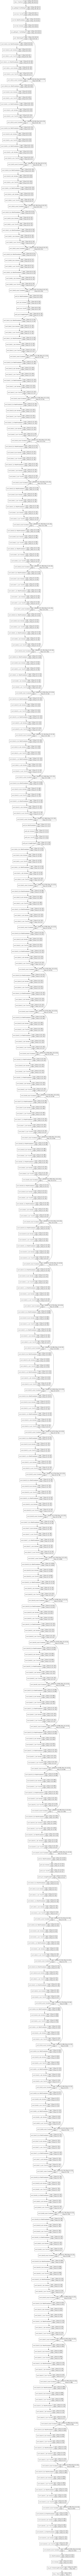

In [68]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB',expand_nested=False)

In [69]:
%load_ext tensorboard
import datetime
folder_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Create log folder - TensorBoard
log_dir="/gdrive/My Drive/Image_segmentation/segmentation/logs/fit/" + folder_name
tensorboard_callback =TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

print('Folder_name', folder_name)


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Folder_name 20210422-041757


In [70]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_dice_coeff', min_delta=0, patience=15, verbose=1, mode='auto',
    baseline=None, restore_best_weights=False
)

#Saving the best model
filepath="new_model_save_test/best_models_Unet_ChexNet.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath,
                                  monitor='val_dice_coeff',
                                  mode='max',
                                  verbose=1,
                                  save_best_only=True)

#lr_callback = ReduceLROnPlateau(min_lr=0.000001,patience=20)

csv_logger = CSVLogger('/gdrive/My Drive/Image_segmentation/segmentation/CSVlogs')



In [71]:
opti = tf.keras.optimizers.Adam(learning_rate=0.001)
unet_chexnet_model.compile(optimizer=opti, loss='binary_crossentropy', metrics=[dice_coeff])



UNET_chexNet = unet_chexnet_model.fit(train_dataset_new,validation_data=test_dataset_new,batch_size=16,
                    epochs=50, verbose=1,
                    callbacks = [checkpoint,early_stop,tensorboard_callback])

Epoch 1/50
134/134 [==============================] - 33s 161ms/step - loss: 0.3010 - dice_coeff: 0.0395 - val_loss: 0.4640 - val_dice_coeff: 0.0876

Epoch 00001: val_dice_coeff improved from -inf to 0.08761, saving model to new_model_save_test/best_models_Unet_ChexNet.hdf5
Epoch 2/50
134/134 [==============================] - 17s 123ms/step - loss: 0.0470 - dice_coeff: 0.1778 - val_loss: 0.0897 - val_dice_coeff: 0.2592

Epoch 00002: val_dice_coeff improved from 0.08761 to 0.25920, saving model to new_model_save_test/best_models_Unet_ChexNet.hdf5
Epoch 3/50
134/134 [==============================] - 17s 123ms/step - loss: 0.0351 - dice_coeff: 0.3089 - val_loss: 0.0521 - val_dice_coeff: 0.3589

Epoch 00003: val_dice_coeff improved from 0.25920 to 0.35888, saving model to new_model_save_test/best_models_Unet_ChexNet.hdf5
Epoch 4/50
134/134 [==============================] - 17s 123ms/step - loss: 0.0291 - dice_coeff: 0.4046 - val_loss: 0.0505 - val_dice_coeff: 0.3931

Epoch 00004: val_di

In [72]:
unet_chexnet_model.load_weights('new_model_save_test/best_models_Unet_ChexNet.hdf5')

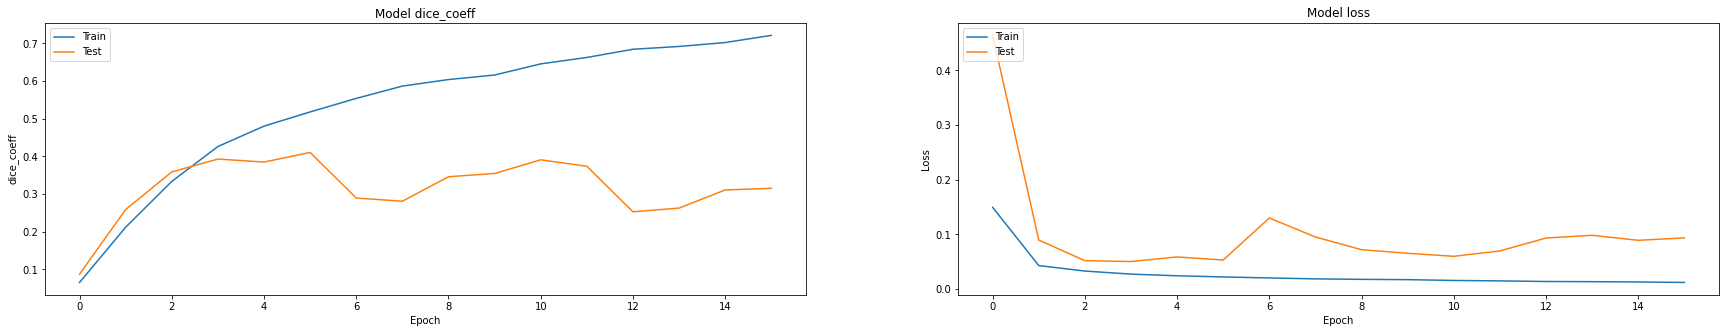

In [73]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(UNET_chexNet.history['dice_coeff'])
plt.plot(UNET_chexNet.history['val_dice_coeff'])
plt.title('Model dice_coeff')
plt.ylabel('dice_coeff')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(UNET_chexNet.history['loss'])
plt.plot(UNET_chexNet.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

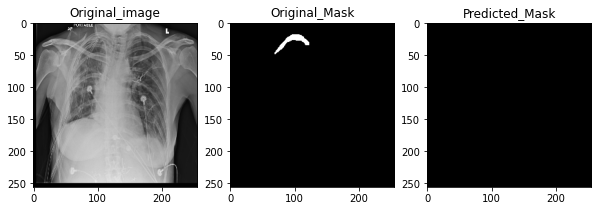

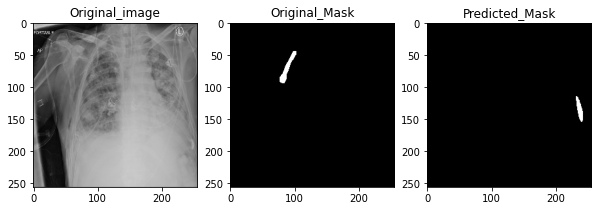

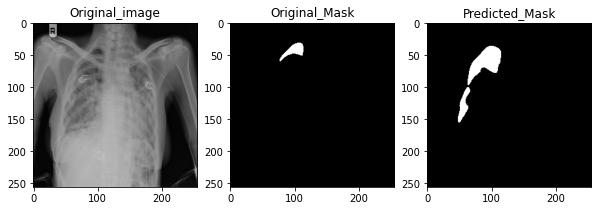

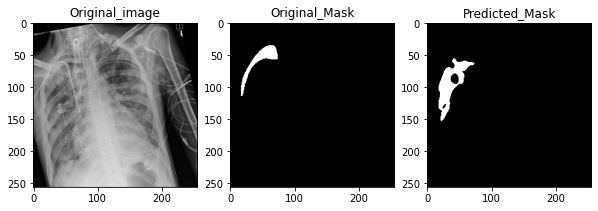

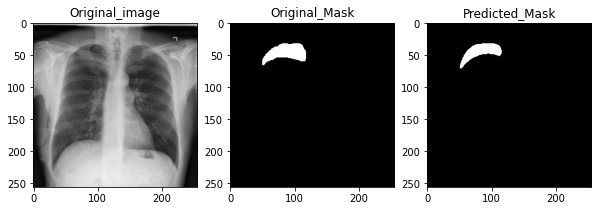

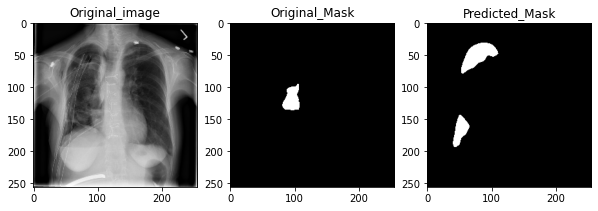

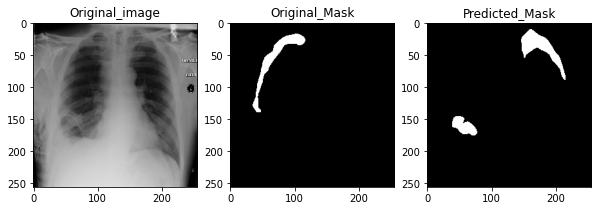

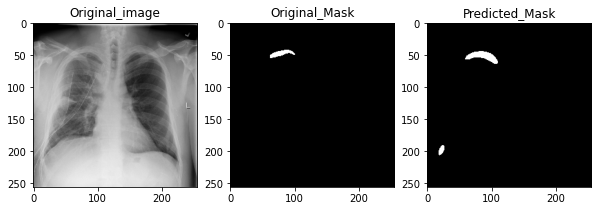

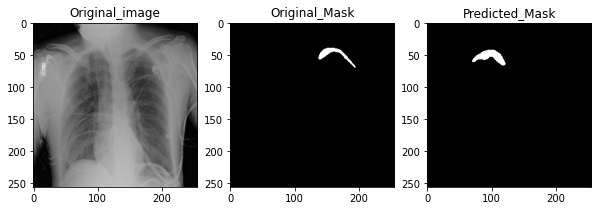

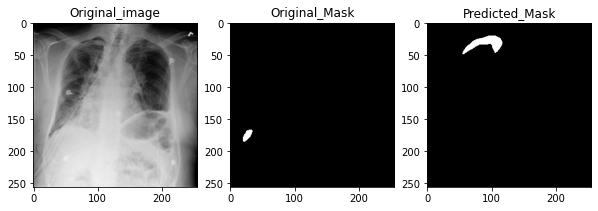

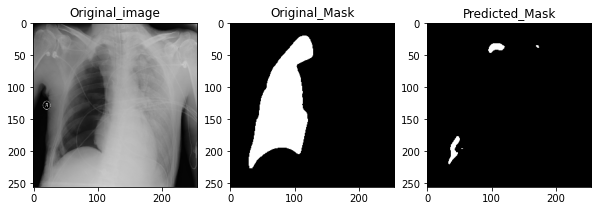

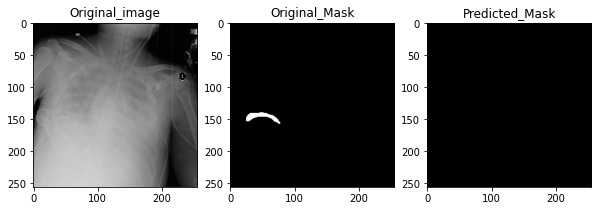

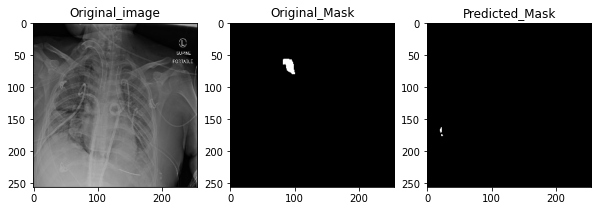

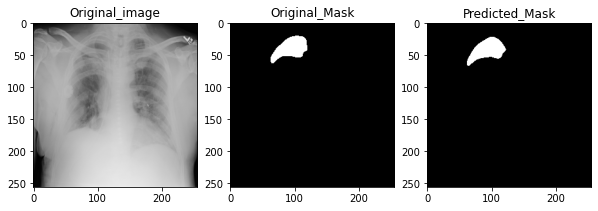

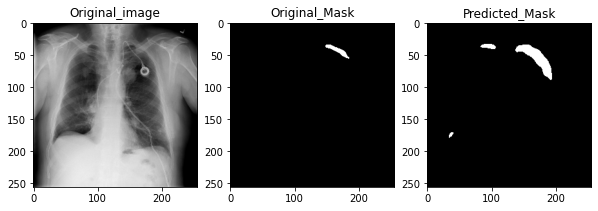

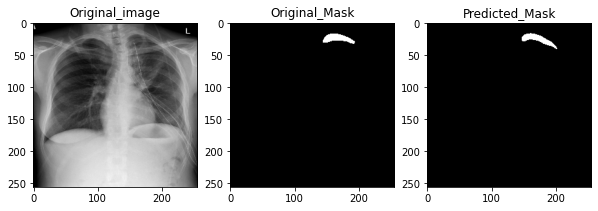

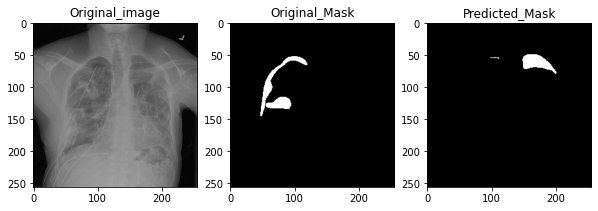

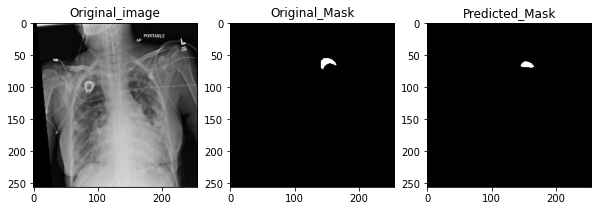

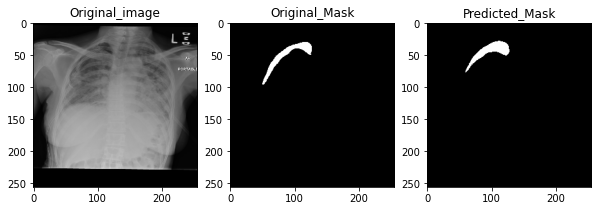

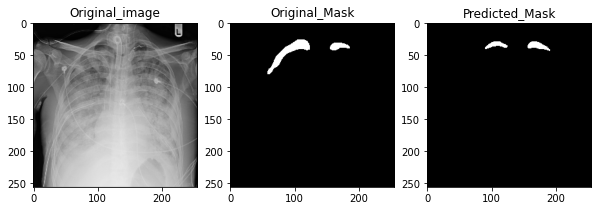

In [74]:
for i,j in test_dataset_new.take(20):
  a = unet_chexnet_model.predict(i)
  pred_val_t = (a[0] >0.5).astype(np.uint8)
  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.title('Original_image')
  plt.imshow(np.squeeze(i[0]),cmap='gray')
  plt.subplot('132')
  plt.title('Original_Mask')
  plt.imshow(np.squeeze(j[0]),cmap='gray')
  plt.subplot('133')
  plt.title('Predicted_Mask')
  plt.imshow(np.squeeze(pred_val_t.astype(np.uint8)),cmap='gray')  
  plt.show()




## Summary 

<pre>
The best model’s performance is <font color ='green'>loss: 0.0202 - dice_coeff: 0.5687 - val_loss: 0.0596 - val_dice_coeff: 0.4067 at the 7th epoch. We have trained this model for 50 epochs.
This model doesn't perform up to the mark.

</pre>

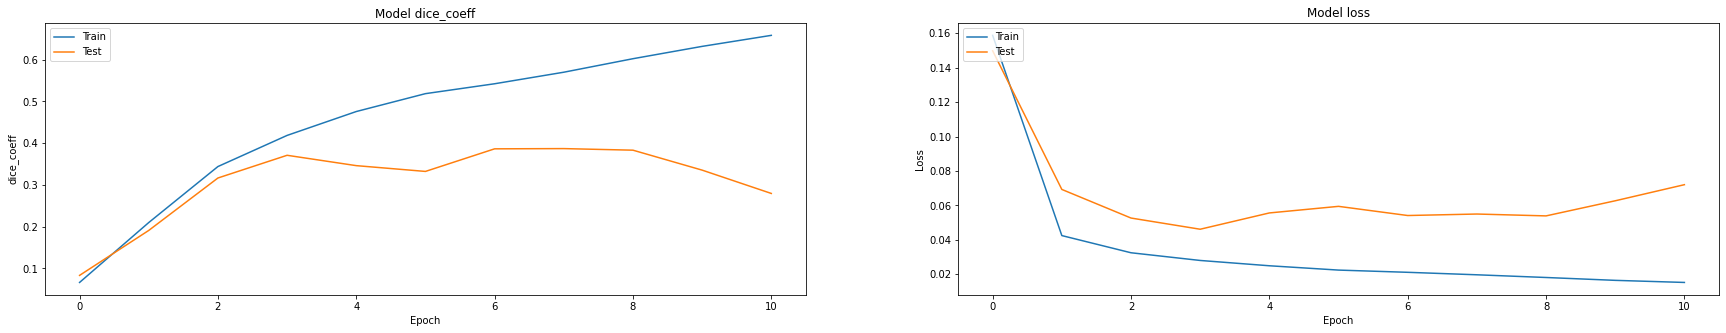

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(UNET_chexNet.history['dice_coeff'])
plt.plot(UNET_chexNet.history['val_dice_coeff'])
plt.title('Model dice_coeff')
plt.ylabel('dice_coeff')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(UNET_chexNet.history['loss'])
plt.plot(UNET_chexNet.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

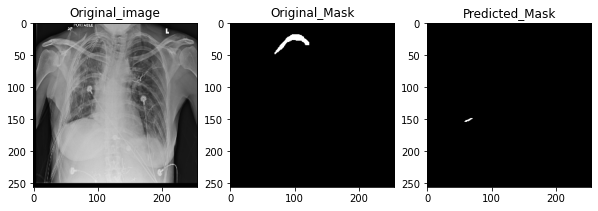

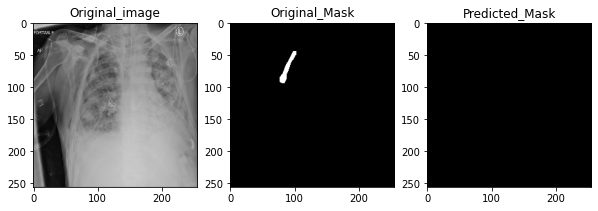

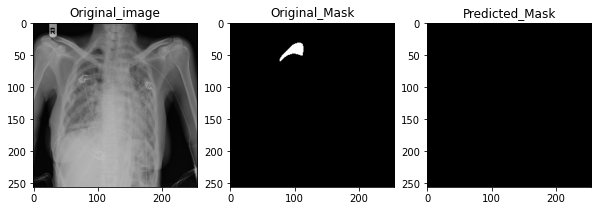

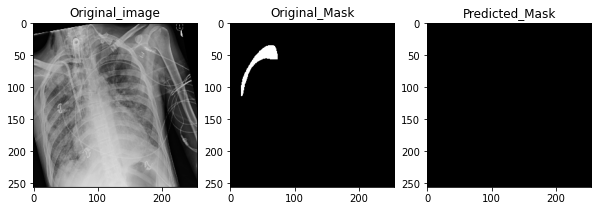

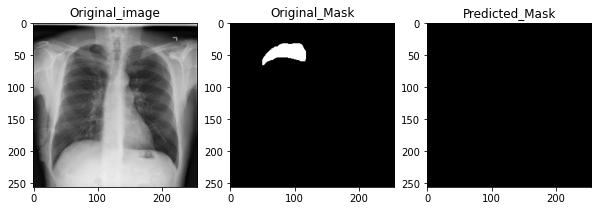

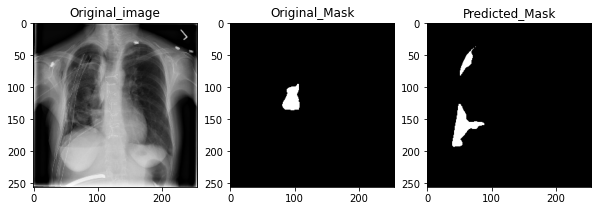

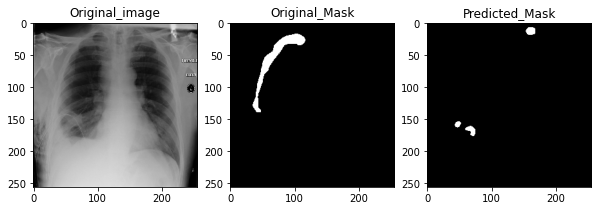

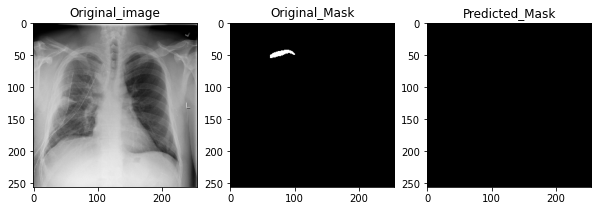

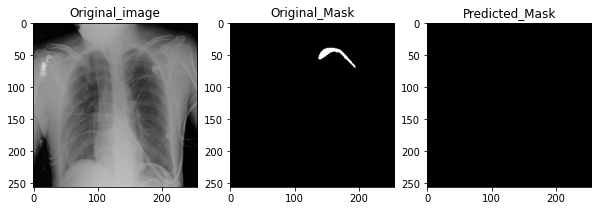

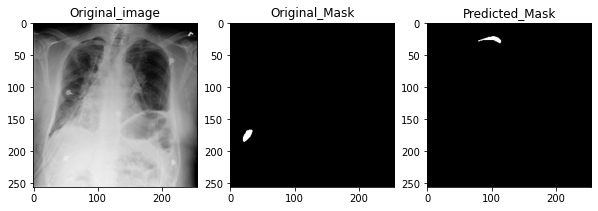

In [ ]:
for i,j in test_dataset_new.take(10):
  a = unet_chexnet_model.predict(i)
  pred_val_t = (a[0] >0.5).astype(np.uint8)
  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.title('Original_image')
  plt.imshow(np.squeeze(i[0]),cmap='gray')
  plt.subplot('132')
  plt.title('Original_Mask')
  plt.imshow(np.squeeze(j[0]),cmap='gray')
  plt.subplot('133')
  plt.title('Predicted_Mask')
  plt.imshow(np.squeeze(pred_val_t.astype(np.uint8)),cmap='gray')  
  plt.show()




## - As the data is too imbalanced, this might be causing some issue. let's try that segmentation only on those positive samples that has mask and we'll see if that helps model to learn more about the data.

In [ ]:
df_main = pd.read_csv('Main_CS2_SIIM_All.csv')

In [ ]:
df_downsampled = df_main[df_main['Encoded_pixel']== '-1']
df_downsampled.drop('UID',axis=1,inplace=True)
df_downsampled.head()

file_path  = df_downsampled['Path'].values
labels     = df_downsampled['Encoded_pixel'].values


mask = np.zeros((len(df_downsampled),256,256,1),dtype=np.bool)

# train and test split
train_path = []
train_mask = []

train_len  = len(df_downsampled)


for i in tqdm(range(len(df_downsampled))):
	train_path.append(file_path[i])
	train_mask.append(mask[i])



train_path = np.array(train_path)
train_ds = tf.data.Dataset.from_tensor_slices((train_path,train_mask))

train_ds = train_ds.map(process_path,num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(augment,num_parallel_calls=AUTOTUNE) 
train_ds = train_ds.map(set_shapes,num_parallel_calls=AUTOTUNE)
train_dataset_new  = train_ds.batch(64).cache().prefetch(1920)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


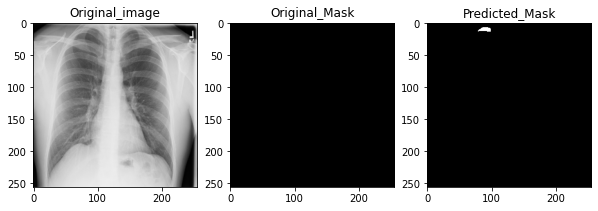

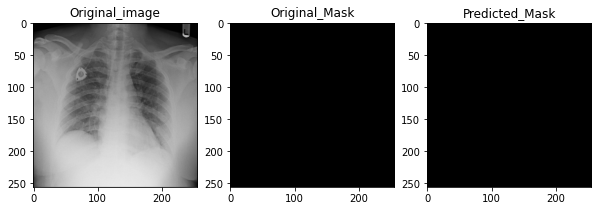

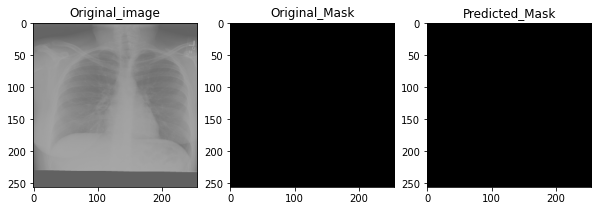

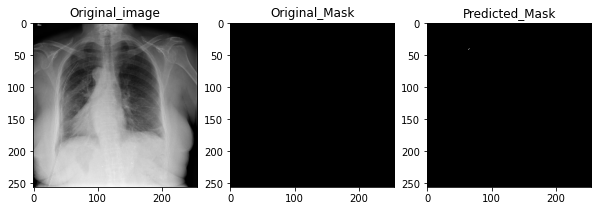

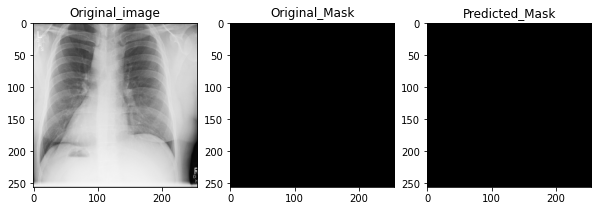

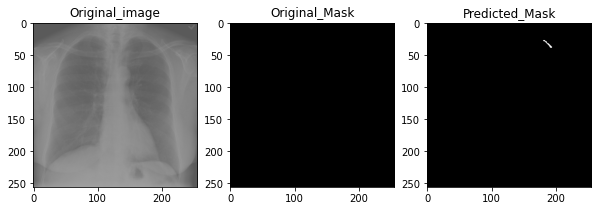

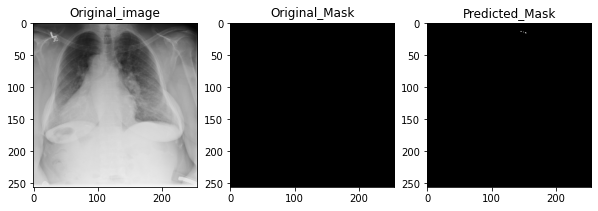

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


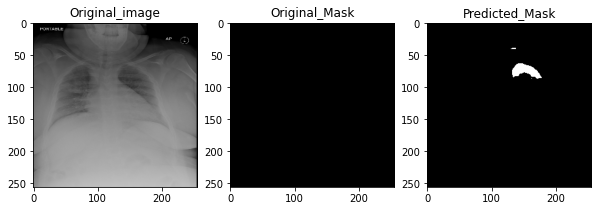

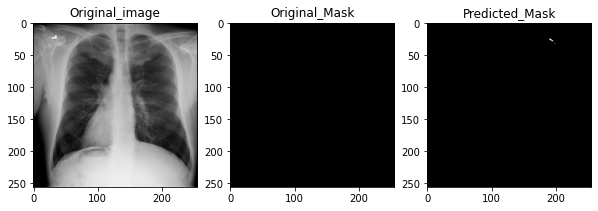

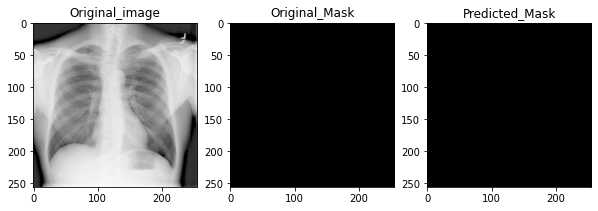

In [ ]:
for i,j in train_dataset_new.take(10):
  a = model.predict(i)
  pred_val_t = (a[0] >0.5).astype(np.uint8)
  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.title('Original_image')
  plt.imshow(np.squeeze(i[0]),cmap='gray')
  plt.subplot('132')
  plt.title('Original_Mask')
  plt.imshow(np.squeeze(j[0]),cmap='gray')
  plt.subplot('133')
  plt.title('Predicted_Mask')
  plt.imshow(np.squeeze(pred_val_t.astype(np.uint8)),cmap='gray')  
  plt.show()

<pre> Postive sample also pretty much working fine. </pre>

<pre> Note - I tried to print augumented dcm file format but not  getting proper response. 
please guide to ensure, after augument if that preserves the actual details of the images or not ?

</pre>